In [10]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import torchsummary
from torchsummary import summary
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from model import LeNet5

In [11]:
model = LeNet5()

In [12]:
# check model structure
summary(model,(1,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
          Layer_C1-2            [-1, 6, 28, 28]               0
              Tanh-3            [-1, 6, 28, 28]               0
          Layer_S2-4            [-1, 6, 14, 14]              12
              Tanh-5            [-1, 6, 14, 14]               0
          Layer_C3-6           [-1, 16, 10, 10]           1,516
              Tanh-7           [-1, 16, 10, 10]               0
          Layer_S4-8             [-1, 16, 5, 5]              32
              Tanh-9             [-1, 16, 5, 5]               0
           Conv2d-10            [-1, 120, 1, 1]          48,120
         Layer_C5-11            [-1, 120, 1, 1]               0
             Tanh-12            [-1, 120, 1, 1]               0
           Linear-13                   [-1, 84]          10,164
             Tanh-14                   

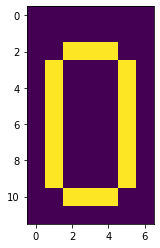

In [13]:
# kernel example 0
file = './RBF_kernel/0_RBF.jpg'
image = cv2.imread(file, 0)
image = cv2.threshold(image,127,1,cv2.THRESH_BINARY)[1]*-1+1
plt.imshow(image)

In [14]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.05,), (0.5,))
    ])

train_data = datasets.MNIST(root='data/', train=True, transform=transform, download=True)
test_data = datasets.MNIST(root='data/', train=False, transform=transform, download=True)

# data loader
train_loader = DataLoader(dataset = train_data, batch_size=256, shuffle=False)
test_loader = DataLoader(dataset = test_data, batch_size=256, shuffle=False)

In [15]:
def train(model, epoch=100, w_decay=0):
    # optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=w_decay)
    
    # loss function
    def loss_fn(output, target):
        loss = output[target==1].pow(2).sum()
        loss += torch.log(np.exp(-0.1)+torch.exp(-output[target==0]).sum())
        return loss

    # training
    train_loss_list=[]
    train_accuracy_list=[]
    for i in range(epoch):
        train_loss = 0
        train_accuracy = 0
        #load data
        for data, target in train_loader:
            data = torch.Tensor(np.pad(data,((0,0),(0,0),(2,2),(2,2)),'constant', constant_values=-0.1))
            target = nn.functional.one_hot(target).float()
            optimizer.zero_grad()

            #forward propagation
            y_pred = model(data)
            loss = loss_fn(y_pred,target)
            
           #backpropagation
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_accuracy += (torch.argmin(model(data),dim=1)==torch.argmax(target,dim=1)).sum().item()


        train_loss /= len(train_loader.dataset)
        train_loss *= 256
        train_loss_list.append(train_loss)

        train_accuracy /= len(train_loader.dataset)
        train_accuracy_list.append(train_accuracy)


        if i%1==0:
            print('epoch : {}/{}, train_loss : {:.8f}, train_acc : {:.2f}'.format(i+1,epoch,train_loss,train_accuracy))
    return(train_loss_list,train_accuracy_list)

In [16]:
def test(model):
    accuracy = 0
    for data, target in test_loader:
        data = torch.Tensor(np.pad(data,((0,0),(0,0),(2,2),(2,2)),'constant', constant_values=-0.1))
        y_pred = model(data)
        accuracy += (torch.argmin(y_pred,dim=1)==target).sum().item()
    accuracy /= len(test_loader.dataset)
    return(accuracy)

In [17]:
train_hist_loss, train_hist_acc = train(model,20)

epoch : 1/20, train_loss : 8779.72153802, train_acc : 0.78
epoch : 2/20, train_loss : 2820.84180911, train_acc : 0.95
epoch : 3/20, train_loss : 1950.66173802, train_acc : 0.96
epoch : 4/20, train_loss : 1619.30782695, train_acc : 0.97
epoch : 5/20, train_loss : 1325.58238203, train_acc : 0.97
epoch : 6/20, train_loss : 1087.58044173, train_acc : 0.98
epoch : 7/20, train_loss : 925.66773652, train_acc : 0.98
epoch : 8/20, train_loss : 818.87937266, train_acc : 0.98
epoch : 9/20, train_loss : 741.80583577, train_acc : 0.98
epoch : 10/20, train_loss : 684.43905036, train_acc : 0.99
epoch : 11/20, train_loss : 631.57666410, train_acc : 0.99
epoch : 12/20, train_loss : 581.03060609, train_acc : 0.99
epoch : 13/20, train_loss : 548.16703737, train_acc : 0.99
epoch : 14/20, train_loss : 525.24357308, train_acc : 0.99
epoch : 15/20, train_loss : 500.21201673, train_acc : 0.99
epoch : 16/20, train_loss : 480.70574997, train_acc : 0.99
epoch : 17/20, train_loss : 456.13778669, train_acc : 0.99


In [18]:
torch.save(model,'LeNet_1998.pt')
test(model)

0.9872